# Study functional switches
## Read data

In [1]:
#source("~/smartas/pipeline/scripts/variablesAndFunctions.r")
library(magrittr)
library(plyr)
source("~/wisdom/r/clean_theme.R")
source("../data/env/variables.R")
options(repr.plot.width=8, repr.plot.height=8)
library(tidyverse)
library(ggstars)

options("readr.num_columns" = 0)

# read switches
switches <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    filter(Origin=="Tumor")
switches.split <- read_tsv("../data/pancancer/candidateList_full.tumorSplit.tsv") %>%
    filter(EnoughRecurrence == 1 & NotNoise==1 & IsModel==1 & Origin=="Tumor")
switches.random <- read_tsv("../data/pancancer/random.candidateList_info.agg.tsv")

# read feature changes
structuralFeatures <- read_tsv('../data/structural_analysis/structural_features.onlyModels.tsv') %>%
    # fix some tags
    mutate(Analysis=revalue(Analysis,c("iupred"="IUPRED","anchor"="ANCHOR","prosite"="ProSite")))

## get real switches
nrStructuralFeatures <- filter(structuralFeatures, Random=="NonRandom") %>%
    # uniq switches from different tumors
    select(-Tumor) %>% unique %>%
    # count only reliable switches
    merge( subset(switches, Reliable==1, select=c("Normal_transcript","Tumor_transcript")))

# read structural summaries
switches.split.structural <- lapply(cancerTypes, function(tumor){
  cancer.structuralSummary <- read_tsv(paste0('../data/structural_analysis/',tumor,'.structural_summary.tsv')) %>%
    mutate(Tumor = tumor, iLoops = iLoops == "True",
           Domain = Domain == "True", Disorder = Disorder == "True",
           Anchor = Anchor == "True", PTM = PTM == "True") %>%
    set_colnames(c("GeneId","Symbol","Normal_transcript","Tumor_transcript",
                   "iLoops","Pfam","IUPRED","ANCHOR","ProSite","Tumor")) %>%
    merge( switches.split %>% 
              filter(Tumor==tumor) %>%
              select(Tumor,GeneId,Symbol,Normal_transcript,Tumor_transcript))
  
  cancer.structuralSummary
    
}) %>% do.call("rbind",.) %>%
    as.data.frame %>%
    merge(switches.split)

# isoform lengths
lengths.random <- read_tsv("../data/switches/isoform_length.random.tsv") %>%
    mutate(nIsoLength = ifelse(nIsoLength==0, NA, nIsoLength),
           tIsoLength = ifelse(tIsoLength==0, NA, tIsoLength),
           Random = ifelse(Random == "NonRandom", "Observed", "Random switches"))
lengths.observed <- read_tsv("../data/switches/isoform_length.tsv") %>%
    mutate(nIsoLength = ifelse(nIsoLength==0, NA, nIsoLength),
           tIsoLength = ifelse(tIsoLength==0, NA, tIsoLength),
           Random = ifelse(Random == "NonRandom", "Observed", "Random switches")) %>%
    # filter out unwanted switches
    merge(switches.split)

lengths <- list("Random switches" = lengths.random, "Observed" = lengths.observed)

# read eporta driver/driver interactor info
driver_info <- read_tsv("../data/num_patients_with_each_switch.txt") %>%
    set_colnames(c("Tumor","Switch","Symbol","Group","NumPatients"))  %>%
    separate(Switch,c("Normal_transcript","Tumor_transcript"),"-") %>%
    mutate(Group=revalue(Group,c("Interaction between drivers"="Driver",
                                 'Interaction with driver'="Driver interactor",
                                 'No driver'="Other"))) %>%
    merge(switches.split) %>%
    group_by(GeneId,Symbol,Normal_transcript,Tumor_transcript,Group) %>%
    summarise(Tumors=paste(Tumor,collapse = ",")) %>%
    ungroup %>% 
    select(GeneId,Symbol,Normal_transcript,Tumor_transcript,Group,Tumors)

# read driver role
read_tsv("../data/intogen_cancer_drivers-2014.12b/Drivers_type_role.tsv")

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
arrange():   dplyr, plyr
compact():   purrr, plyr
count():     dplyr, plyr
failwith():  dplyr, plyr
filter():    dplyr, stats
id():        dplyr, plyr
lag():       dplyr, stats
mutate():    dplyr, plyr
rename():    dplyr, plyr
summarise(): dplyr, plyr
summarize(): dplyr, plyr
Warning message:
“499 parsing failures.
row col  expected    actual
  7  -- 1 columns 4 columns
  8  -- 1 columns 4 columns
  9  -- 1 columns 4 columns
 10  -- 1 columns 4 columns
 11  -- 1 columns 4 columns
... ... ......... .........
See problems(...) for more details.
”

#List of 475 drivers. driver type and its role in cancer
#
##geneHGNCsymbol
##Driver_type = whether it is a mutational driver (MUTATION). a CNA driver (CNA) or a fusion driver (FUSION)
##Role = Between Activating. Loss of function or No class. Retrieved from OncodriveROLE for mutational drivers. Remaining driver role was established through coherent manual annotation.
##OncodriveROLE_prob = OncodriveROLE results for 459 mutational drivers
###
geneHGNCsymbol
ABL1
ABL2
ACACA


In [2]:
driver_role <- read_tsv("../data/intogen_cancer_drivers-2014.12b/Drivers_type_role.tsv", comment = "#") %>%
    filter(Driver_type == "MUTATION" & Role != "No class") %>%
    mutate(Role = recode(Role, "Activating" = "Oncogene", 
                               "Loss of function" = "Tumor suppressor")) %>%
    rename(Symbol = geneHGNCsymbol)

# Some numbers

In [3]:
reliable <- switches.split %>%
    .$Tumor %>% table
functional <- switches.split %>%
    filter(IsFunctional==1)  %>%
    .$Tumor %>% table
candidate <- switches.split %>%
    filter(IsFunctional==1 & Candidate==1 & Origin=="Tumor")  %>%
    .$Tumor %>% table

do.call("rbind", list(reliable,functional,candidate)) %>%
    t %>%
    as.data.frame %>%
    set_colnames(c("Reliable","Functional","Candidate")) %>%
    mutate(., Tumor = rownames(.),
           Functional = paste0(Functional, " (", round( Functional/Reliable * 100, 2),"%)"),
           Candidate = paste0(Candidate, " (", round( Candidate/Reliable * 100, 2), "%)")) %>%
    select(Tumor,Reliable,Functional,Candidate)

Tumor,Reliable,Functional,Candidate
brca,1335,931 (69.74%),381 (28.54%)
coad,1021,672 (65.82%),237 (23.21%)
hnsc,2203,1660 (75.35%),587 (26.65%)
kich,1761,1329 (75.47%),506 (28.73%)
kirc,1972,1475 (74.8%),584 (29.61%)
kirp,3156,2376 (75.29%),826 (26.17%)
lihc,636,476 (74.84%),145 (22.8%)
luad,1329,911 (68.55%),371 (27.92%)
lusc,1618,1084 (67%),390 (24.1%)
prad,1355,1001 (73.87%),394 (29.08%)


This are the switches reliable without any a priori pancancer analysis other than the recurrence filter.

In [4]:
splitted <- switches %>%
    filter(Reliable==1) %>%
    mutate(Tumor = strsplit(Tumors, ",")) %>%
    unnest(Tumor)

# Switch
switch.reliable <- splitted %>%
    .$Tumor %>% table
switch.functional <- splitted %>%
    filter(IsFunctional==1)  %>%
    .$Tumor %>% table
switch.candidate <- splitted %>%
    filter(IsFunctional==1 & Candidate==1)  %>%
    .$Tumor %>% table

# Gene
gene.reliable <- splitted %>%
    select(GeneId,Tumor) %>% unique %>%
    .$Tumor %>% table
gene.functional <- splitted %>%
    filter(IsFunctional==1)  %>%
    select(GeneId,Tumor) %>% unique %>%
    .$Tumor %>% table
gene.candidate <- splitted %>%
    filter(IsFunctional==1 & Candidate==1)  %>%
select(GeneId,Tumor) %>% unique %>%
    .$Tumor %>% table

do.call("rbind", list(switch.reliable,switch.functional,switch.candidate,
                      gene.reliable,gene.functional,gene.candidate)) %>%
    t %>% as.data.frame %>%
    set_colnames(c("Switch.Reliable","Switch.Functional","Switch.Candidate",
                   "Gene.Reliable","Gene.Functional","Gene.Candidate")) %>%
    mutate(., Tumor = rownames(.),
           Switch.Functional = paste0(Switch.Functional, " (", round( Switch.Functional/Switch.Reliable * 100, 2),"%)"),
           Switch.Candidate = paste0(Switch.Candidate, " (", round( Switch.Candidate/Switch.Reliable * 100, 2), "%)"),
           Gene.Functional = paste0(Gene.Functional, " (", round( Gene.Functional/Gene.Reliable * 100, 2),"%)"),
           Gene.Candidate = paste0(Gene.Candidate, " (", round( Gene.Candidate/Gene.Reliable * 100, 2), "%)")) %>%
    select(Tumor,Switch.Reliable,Switch.Functional,Switch.Candidate,
           Gene.Reliable,Gene.Functional,Gene.Candidate)

Tumor,Switch.Reliable,Switch.Functional,Switch.Candidate,Gene.Reliable,Gene.Functional,Gene.Candidate
brca,3538,2552 (72.13%),761 (21.51%),3157,2307 (73.08%),724 (22.93%)
coad,2479,1739 (70.15%),537 (21.66%),2232,1570 (70.34%),512 (22.94%)
hnsc,3704,2760 (74.51%),837 (22.6%),3271,2460 (75.21%),795 (24.3%)
kich,3131,2343 (74.83%),795 (25.39%),2852,2170 (76.09%),766 (26.86%)
kirc,4454,3321 (74.56%),997 (22.38%),3876,2938 (75.8%),937 (24.17%)
kirp,4523,3365 (74.4%),1047 (23.15%),3962,3001 (75.74%),988 (24.94%)
lihc,2464,1830 (74.27%),530 (21.51%),2290,1724 (75.28%),515 (22.49%)
luad,3598,2583 (71.79%),841 (23.37%),3178,2325 (73.16%),805 (25.33%)
lusc,3488,2486 (71.27%),790 (22.65%),3066,2222 (72.47%),752 (24.53%)
prad,3249,2391 (73.59%),724 (22.28%),2907,2158 (74.23%),685 (23.56%)


## Study the changing functional feature

The diagram shows the type of the affected features in the functional switches from all tumor types. The main feature affected are disordered regions, a large fraction of which might be involved in interactions. Changes in Pfam domains are the second most numerous group. ProSite and Pfam share a considerable number of switches

In [5]:
sum(switches.split.structural$Pfam & switches.split.structural$ProSite)

[1] 3194

This is not surprising, given that both databases overlap to a certain extent. Lastly ArchDB loops are the forth most numerous group 

In [6]:
sum(switches.split.structural$iLoops)

[1] 5576

Out of them, 

In [7]:
sum(switches.split.structural$iLoops & !rowSums(switches.split.structural[,c("Pfam","IUPRED","ANCHOR")]))

[1] 694

switches exclusively exhibit a change in loops.

Loading required package: RColorBrewer
Warning message:
“Removed 2862 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 2862 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 436503 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 436503 rows containing non-finite values (stat_boxplot).”

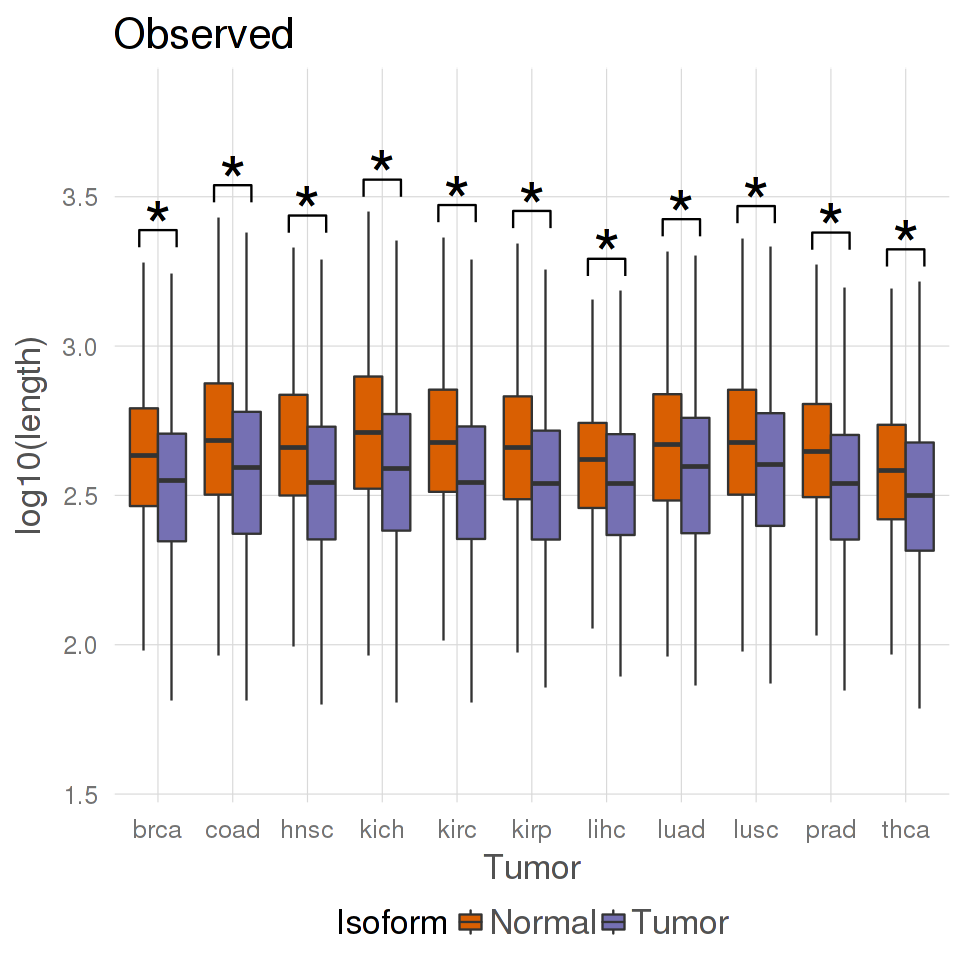

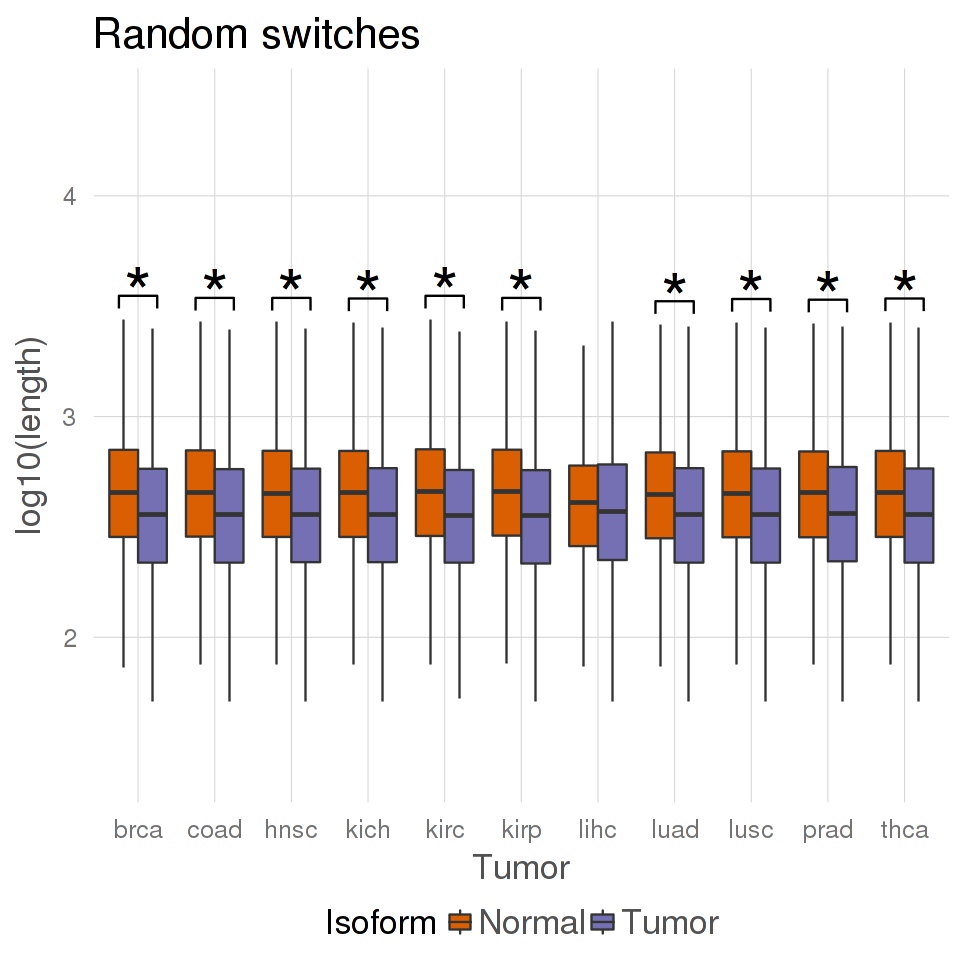

In [8]:
for (r in c("Observed", "Random switches")){
  
    this.isoLengths <- lengths[[r]]
    
    isoLengths.melt <- this.isoLengths %>%
        select(Tumor, nIsoLength, tIsoLength) %>% 
        reshape2::melt(id.vars = "Tumor", variable.name = "IsoformOrigin", value.name = "Length") %>% 
        mutate(IsoformOrigin = ifelse(IsoformOrigin == "nIsoLength", "Normal", "Tumor"))
  
    # get ranges and convert to log10 scale
    tumorEnrichment <- this.isoLengths %>%
        group_by(Tumor) %>%
        summarise(p = t.test(nIsoLength,tIsoLength,paired=TRUE,alternative="greater")$p.value )
    
    ranges <- isoLengths.melt %>%
        mutate(Length = log10(Length)) %>%
        filter(!is.na(Length)) %>%
        set_colnames(c("Cancer","Categories","y"))
  
    tests <- this.isoLengths %>%
        filter(!is.na(nIsoLength) & !is.na(tIsoLength)) %>%
        group_by(Tumor) %>%
        summarise(mean_nIso = mean(nIsoLength),
                  mean_tIso = mean(tIsoLength),
                  mean_diff = mean(nIsoLength-tIsoLength)) %>%
        merge(tumorEnrichment) %>%
        set_colnames(c("Cancer","mean_nIso","mean_tIso", "mean_diff","p"))
  
    # plot isoform length
    p <- ggplot(isoLengths.melt) + 
        geom_boxplot(aes(factor(Tumor),log10(Length),fill=IsoformOrigin), outlier.colour = NA) + 
        clean_theme() + 
        labs(x="Tumor",y="log10(length)",fill="Isoform", title=r) +
        scale_fill_manual(values=c("#d95f02","#7570b3")) +
        theme(legend.position="bottom")
  
    p <- star_box(p, tests$p < 0.05)
  
    print(p)
  
}

In all tumor types, the normal isoform is significantly longer than the tumor isoform, which is paired to a loss of features. We compared our switches with random switches, generated assuming the normal isoform is the most abundant in normal tissue, and the tumor isoform one of the expressed transcripts at random. This phenomenon also happens in the random data, though, so probably has to do with the most expressed isoform being longer.

In [9]:
# compare results vs random
rStructuralFeatures <- structuralFeatures[structuralFeatures$Random=="Random",]

rStructuralFeatures.counts <- rStructuralFeatures %>%
    group_by(Analysis) %>%
    summarize(Gains=sum(grepl("Gained",WhatsHappenning)),
              Losses=sum(grepl("Lost",WhatsHappenning)))

nrStructuralFeatures.counts <- nrStructuralFeatures %>%
    group_by(Analysis) %>%
    summarize(Gains=sum(grepl("Gained",WhatsHappenning)),
              Losses=sum(grepl("Lost",WhatsHappenning)))

structuralFeatures.counts <- merge(nrStructuralFeatures.counts,rStructuralFeatures.counts,
                                   by="Analysis",suffixes=c("",".random"))

f <- apply(structuralFeatures.counts[,c(3,5,2,4)],1,function(x){
  f <- fisher.test(matrix(x,2,2))
  c(p=f$p.value,OR=f$estimate)
}) %>%
    t %>%
    as.data.frame %>%
    set_colnames(c("p","OR")) %>%
    mutate(p = ifelse(p==0, 1e-300, p))

structuralFeatures.counts <- cbind(structuralFeatures.counts,f)

structuralFeatures.counts

Analysis,Gains,Losses,Gains.random,Losses.random,p,OR
ANCHOR,4707,14425,2215263,4512854,7.553642e-139,1.504338
IUPRED,7702,21238,3401162,6858382,1.155980e-127,1.367485
Pfam,699,3052,485611,1421408,4.405180e-23,1.491644
ProSite,605,2296,331247,975136,1.449076e-08,1.289137


Given that the most expressed isoform tends to be longer, the gains are rarer than the losses both in random switches and non-random switches. Even so, switches a higher tendency than random switches to lose more features. This suggests that the loss of a protein segment is more meaningful than what is expected at random.

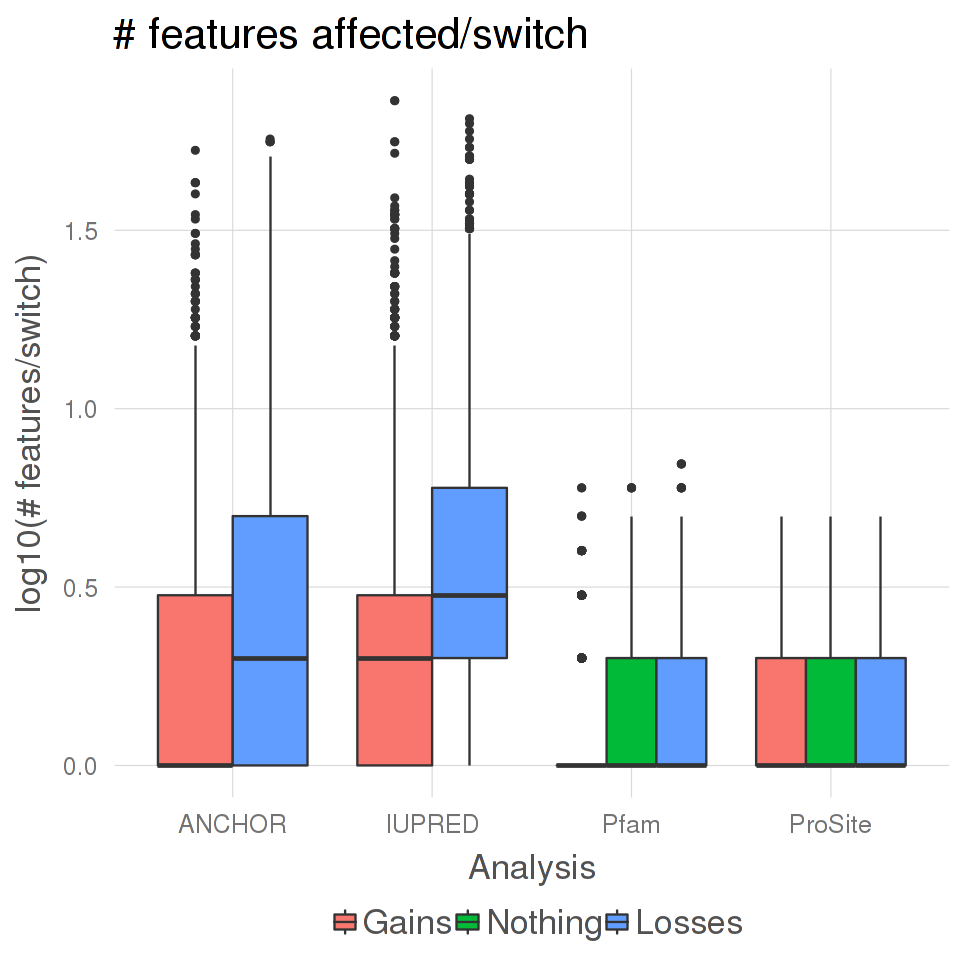

In [10]:
# count the number of gains and losses per switch
nrStructuralFeatures %>%
    merge(switches.split) %>%
    group_by(Tumor,GeneId,Symbol,Normal_transcript,Tumor_transcript,Analysis) %>%
    summarize(Gains=sum(grepl("Gained",WhatsHappenning)),
              Nothing=sum(grepl("Nothing",WhatsHappenning)),
              Losses=sum(grepl("Lost",WhatsHappenning))) %>%
    reshape2::melt(id.vars = 1:6) %>%
    filter(value != 0) %>%
    ggplot() + 
    geom_boxplot(aes(x=Analysis, y=log10(value), fill=variable)) + 
    clean_theme() + 
    labs(y="log10(# features/switch)",title="# features affected/switch",fill="") +
    theme(legend.position="bottom")

For all the studied features, the loss of features is prevalent, specially so in Pfam domains and ProSite patterns. Most of the switches affect less than 10 features, being disordered  features more, which makes sense, given that they are also shorter.

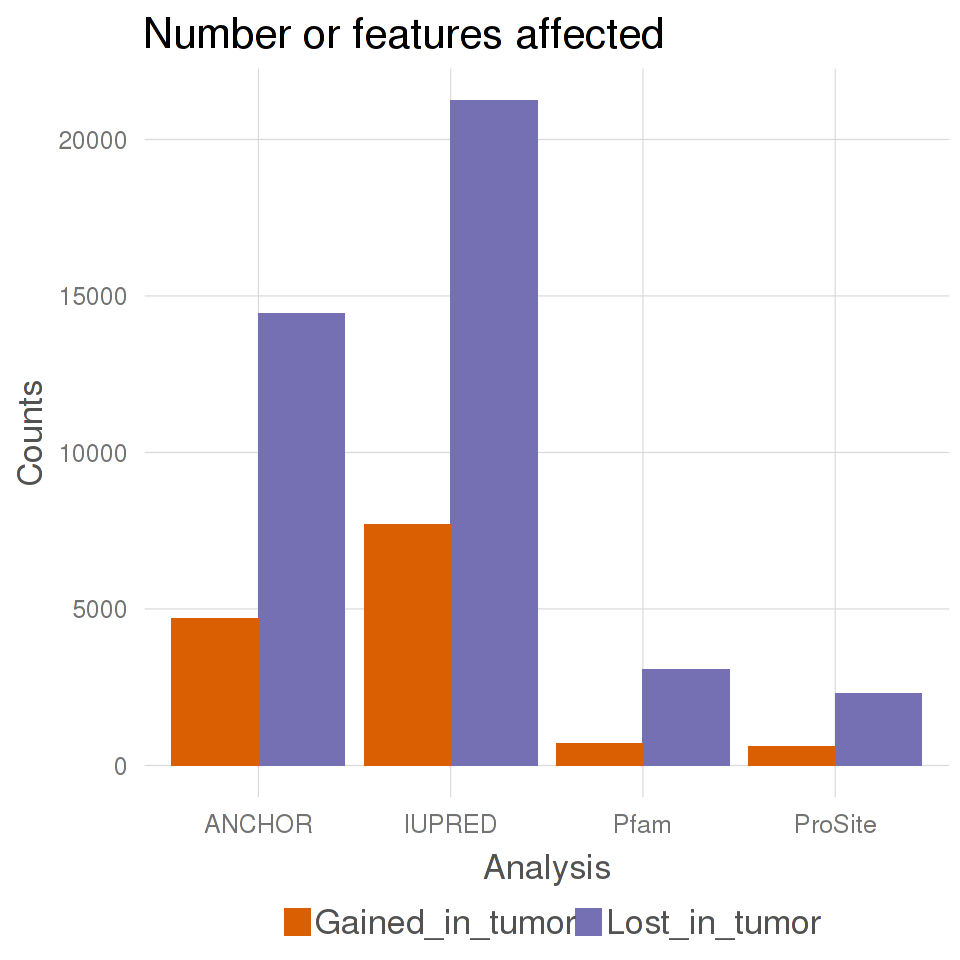

In [11]:
# count the number of gains and losses per category
ggplot(data=subset(nrStructuralFeatures,WhatsHappenning!="Nothing"),aes(Analysis,fill=WhatsHappenning)) + 
  geom_bar(position="dodge") + 
  labs(y="Counts",title="Number or features affected",fill="") +
  clean_theme() +
  theme(legend.position="bottom") + 
  scale_fill_manual(values=c("#d95f02","#7570b3"))

The number of features being lost is way higher than the number of them being gained. Coherently with the previous plot, disordered features are more abundant than structured ones.

Using Analysis as id variables
Using Analysis as id variables
Using Analysis as id variables
Using Analysis as id variables
Using Analysis as id variables
Using Analysis as id variables


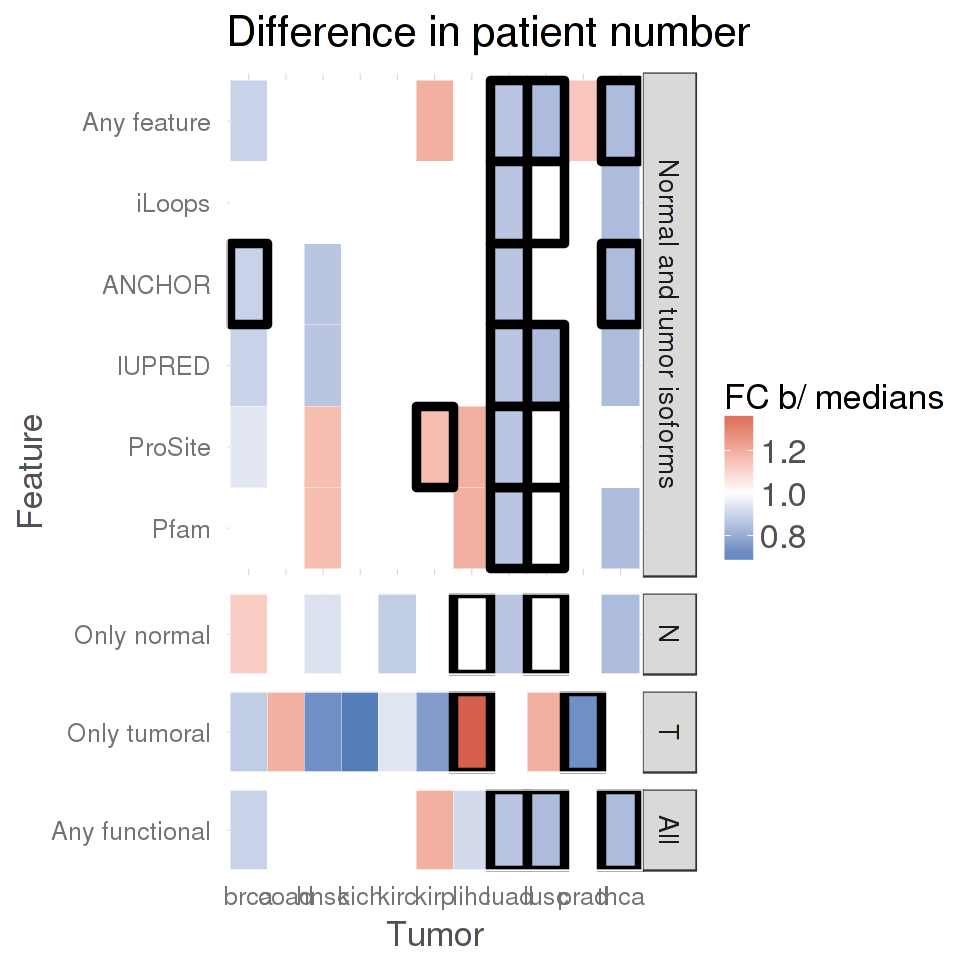

In [12]:
pvals <- list(np=data.frame(),d0=data.frame(),d1=data.frame())
oddsratios <- list(np=data.frame(),d0=data.frame(),d1=data.frame())
oddsratios.m <- list()

for (f in c("Pfam","ProSite","IUPRED","ANCHOR","iLoops","Only normal","Only tumoral","Any feature", "Any functional")){
  
    if (f=="Any feature"){
        v <- as.logical(rowSums(switches.split.structural %>% select(Pfam,ProSite,IUPRED,ANCHOR,iLoops)))
        switches.affected <- switches.split.structural %>% filter(v & CDS_Normal==1 & CDS_Tumor==1)
        switches.unaffected <- switches.split.structural %>% filter(!(v & CDS_Normal==1 & CDS_Tumor==1))
    } else if (f=="Only normal") {
        switches.affected <- switches.split.structural %>% filter(CDS_Normal==1 & CDS_Tumor==0)
        switches.unaffected <- switches.split.structural %>% filter(!(CDS_Normal==1 & CDS_Tumor==0))
    } else if (f=="Only tumoral") {
        switches.affected <- switches.split.structural %>% filter(CDS_Normal==0 & CDS_Tumor==1)
        switches.unaffected <- switches.split.structural %>% filter(!(CDS_Normal==0 & CDS_Tumor==1))
    } else if (f=="Any functional") {
        switches.affected <- switches.split.structural %>% filter(IsFunctional==1)
        switches.unaffected <- switches.split.structural %>% filter(IsFunctional==0)
    } else {
        v <- switches.split.structural[, colnames(switches.split.structural)==f]
        switches.affected <- switches.split.structural[v,]
        switches.unaffected <- switches.split.structural[!v,]
    }
    
    switches.affected <- switches.affected %>% select(Tumor,GeneId,Symbol,Normal_transcript,Tumor_transcript)
    switches.unaffected <- switches.unaffected %>% select(Tumor,GeneId,Symbol,Normal_transcript,Tumor_transcript)

    p <- list(np=c(),d0=c(),d1=c())
    or <- list(np=c(),d0=c(),d1=c())
  
    for (c in cancerTypes){
        switches.affected.cancer <- switches.affected %>%
            filter(Tumor==c) %>% select(GeneId,Symbol,Normal_transcript,Tumor_transcript)
        switches.unaffected.cancer <- switches.unaffected %>%
            filter(Tumor==c) %>% select(GeneId,Symbol,Normal_transcript,Tumor_transcript)
        
        switchesInfo.cancer <- subset(switches.split, Tumor==c)
    
        x <- merge(switchesInfo.cancer,switches.affected.cancer)
        y <- merge(switchesInfo.cancer,switches.unaffected.cancer)
    
        np <- wilcox.test(x$PatientNumber,y$PatientNumber)
        p[["np"]] <- c(p[["np"]],np$p.value)
        or[["np"]] <- c(or[["np"]],median(x$PatientNumber)/median(y$PatientNumber))

        d0 <- fisher.test(matrix(c(sum(as.logical(x$Driver)),sum(!as.logical(x$Driver)),
                               sum(as.logical(y$Driver)),sum(!as.logical(y$Driver))),2,2))
        p[["d0"]] <- c(p[["d0"]],d0$p.value)
        or[["d0"]] <- c(or[["d0"]],d0$estimate)

        d1 <- fisher.test(matrix(c(sum(x$DriverAnnotation=="d1"),sum(x$DriverAnnotation!="d1"),
                               sum(y$DriverAnnotation=="d1"),sum(y$DriverAnnotation!="d1")),2,2))
        p[["d1"]] <- c(p[["d1"]],d1$p.value)
        or[["d1"]] <- c(or[["d1"]],d1$estimate) 
    }
  
    for (a in c("np","d0","d1")){
        pvals[[a]] <- rbind(pvals[[a]],p[[a]])
        oddsratios[[a]] <- rbind(oddsratios[[a]],or[[a]])
    }
}

for (a in c("np","d0","d1")){
  significance <- pvals[[a]]
  significance[pvals[[a]] < 0.05] <- TRUE
  significance[pvals[[a]] >= 0.05] <- FALSE
  colnames(significance) <- cancerTypes
  significance$Analysis <- c("Pfam","ProSite","IUPRED","ANCHOR","iLoops","Only normal"
                             ,"Only tumoral","Any feature", "Any functional")
  
  colnames(oddsratios[[a]]) <- cancerTypes
  oddsratios[[a]]$Analysis <- c("Pfam","ProSite","IUPRED","ANCHOR","iLoops","Only normal",
                                "Only tumoral","Any feature", "Any functional")

  or.m <- reshape2::melt(oddsratios[[a]])
  colnames(or.m) <- c("Analysis","Cancer","OR")
  significance.m <- reshape2::melt(significance)
  colnames(significance.m) <- c("Analysis","Cancer","Significant")
  significance.m$Significant <- as.factor(significance.m$Significant)
  
  oddsratios.m[[a]] <- merge(or.m,significance.m)
  oddsratios.m[[a]]$Analysis <- factor(oddsratios.m[[a]]$Analysis,
                                       levels=c("Pfam","ProSite","IUPRED","ANCHOR","iLoops",
                                                "Only normal","Only tumoral","Any feature", "Any functional"))
  oddsratios.m[[a]]$Category <- factor("Normal and tumor isoforms",
                                       levels=c("Normal and tumor isoforms","N","T","All"))
  oddsratios.m[[a]]$Category[oddsratios.m[[a]]$Analysis == "Only normal"] <- "N"
  oddsratios.m[[a]]$Category[oddsratios.m[[a]]$Analysis == "Only tumoral"] <- "T"
  oddsratios.m[[a]]$Category[oddsratios.m[[a]]$Analysis == "Any functional"] <- "All"

}

ggplot() + 
  geom_tile(data=subset(oddsratios.m[["np"]], Significant==0),aes(x=Cancer,y=Analysis,fill=OR), color = "white") +
  geom_tile(data=subset(oddsratios.m[["np"]], Significant==1),aes(x=Cancer,y=Analysis,fill=OR), color = "black", size=2) +
  scale_fill_gradient2(low = "#2166ac", high = "#d6604d", mid= "white", space="Lab", midpoint = 1) +
  clean_theme() +
  labs(x="Tumor",y="Feature",title="Difference in patient number",fill="FC b/ medians") +
  theme(legend.position="right") +
  facet_grid(Category ~ ., space = "free", scales="free_y") +
  coord_fixed()

Here, we compare different subsets of switches agains the rest, testing if the distribution of patients affected is different. Given that we could consider the spread of a switch as surrogate for selection, this could point the most important features. We observe that, comparing the switches that involve two protein-coding transcripts and change a protein feature against the rest, those tend to happen more patients. We observe the same with the switches where only the normal transcripts encodes a protein. And the opposite in the cases where only the tumor transcript encodes a protein. This is coherent with the previously sketched idea that switches are more related to a loss of function than to a gain of function.

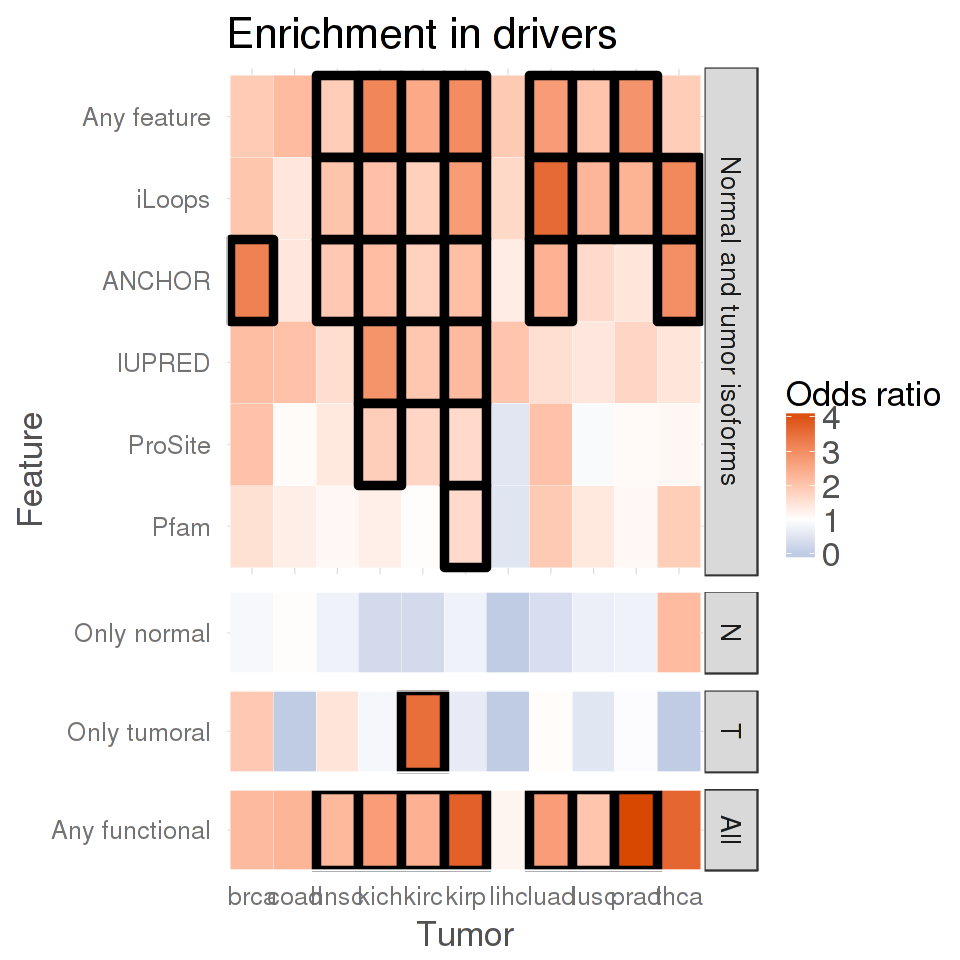

In [13]:
ggplot() + 
  geom_tile(data=subset(oddsratios.m[["d0"]], Significant==0),aes(x=Cancer,y=Analysis,fill=OR), color = "white") +
  geom_tile(data=subset(oddsratios.m[["d0"]], Significant==1),aes(x=Cancer,y=Analysis,fill=OR), color = "black", size=2) +
  scale_fill_gradient2(low = "#2166ac", high = "#d94801", mid="white", space = "Lab", midpoint=1) +
  clean_theme() +
  labs(x="Tumor",y="Feature",title="Enrichment in drivers",fill="Odds ratio") +
  theme(legend.position="right") +
  facet_grid(Category ~ ., space = "free", scales="free_y") +
  coord_fixed()

In this case, we look for unbalances in the distribution of drivers. Again, it seems that switches in drivers tend to affect protein features. In the other hand, the switches with only one protein-coding isoform are underrepresented in switches in general.


	Fisher's Exact Test for Count Data

data:  .
p-value = 2.034e-05
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.409049 2.799303
sample estimates:
odds ratio 
  1.965563 


      IsFunctional
Driver    0    1
     0 2075 5769
     1   43  235

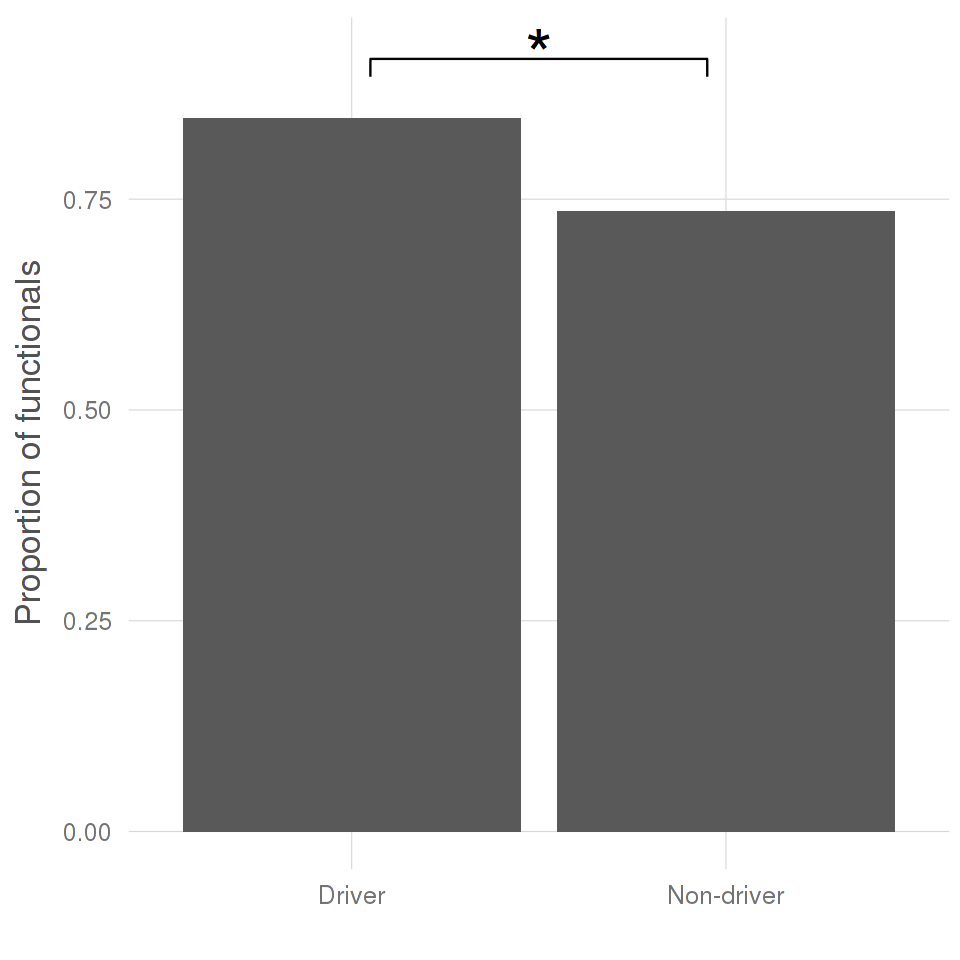

In [14]:
# test if drivers are enriched in functional
switches %>%
    filter(Reliable == 1) %>%
    select(Driver,IsFunctional) %>%
    table %>%
    fisher.test

# table
switches %>%
    filter(Reliable == 1) %>%
    select(Driver,IsFunctional) %>%
    table

# plot
p <- switches %>%
    filter(Reliable == 1) %>%
    group_by(Driver) %>%
    summarize(IsFunctional = sum(IsFunctional)/n()) %>%
    mutate(Driver = ifelse(Driver == 1, "Driver", "Non-driver")) %>%
    ggplot(aes(x=Driver, y = IsFunctional)) +
        geom_bar(stat="identity") +
        clean_theme() + 
        labs(x = "", y = "Proportion of functionals", fill = "") +
        theme(legend.position="bottom") + 
        scale_fill_manual(values = c("Functional" = "gray30", "Non-functional" = "white"))
star_bar(p, c(TRUE), fit = FALSE, dist = 0.05)

In [15]:
# check if different drivers-types have different enrichments in coding/non-coding switches
t <- switches %>%
    filter(Reliable == 1 & IsFunctional == 1) %>%
    merge(driver_role, all.x = TRUE) %>%
    mutate(Role = ifelse(is.na(Role), "Other", Role),
           Coding_Noncoding = CDS_Tumor != CDS_Normal) %>%
    select(Role, Coding_Noncoding) %>%
    table

t
chisq.test(t)

                  Coding_Noncoding
Role               FALSE TRUE
  Oncogene            83   11
  Other             4877  934
  Tumor suppressor    87   12


	Pearson's Chi-squared test

data:  t
X-squared = 2.4142, df = 2, p-value = 0.2991


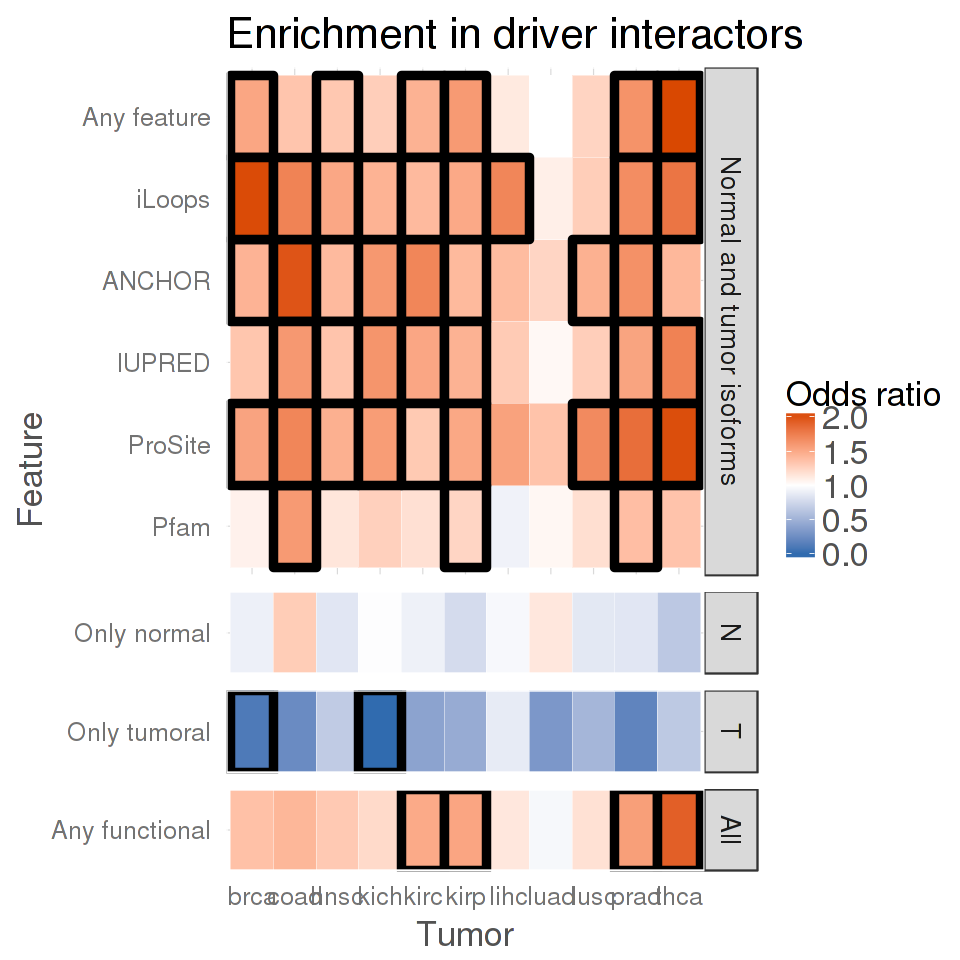

In [16]:
ggplot() + 
  geom_tile(data=subset(oddsratios.m[["d1"]], Significant==0),aes(x=Cancer,y=Analysis,fill=OR), color = "white") +
  geom_tile(data=subset(oddsratios.m[["d1"]], Significant==1),aes(x=Cancer,y=Analysis,fill=OR), color = "black", size=2) +
  scale_fill_gradient2(low = "#2166ac", high = "#d94801", mid="white", space = "Lab", midpoint=1) +
  clean_theme() +
  labs(x="Tumor",y="Feature",title="Enrichment in driver interactors",fill="Odds ratio") +
  theme(legend.position="right") +
  facet_grid(Category ~ ., space = "free", scales="free_y") +
  coord_fixed()

The trend observed in drivers is similar for driver-interactors.

# Analyses not shown
(See Sup Fig 3C). We studied all the genes that show evidence of regulated splicing ie show more than one transcript with median TPM > 0.1 in normal and/or tumor or a switch in at least one patient. We divided those sets in drivers and non-drivers and checked whether the groups had different tendencies to get switched. Driver genes seem to undergo a switch more frequently than the rest in some tumors. Then, we took all the genes, excluding the drivers, and classified them in driver interactors and others. We still observe that driver interactors are more likely to undergo a switch than non-driver-interactors. When we consider only the switches that involve a functional change, the switches the tendency is higher. Drivers and driver interactors are involved in key processes. Hence, their affectation by switches could be straightforward related to some classic processes.